## popol_project_modeling

### 1.import

In [1]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

### 2.데이터셋 클래스 정의

In [2]:
# MediaPipe 손 모델 초기화
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

class HandDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        
        if idx >= len(self.image_paths):
            raise IndexError(f"Index {idx} out of range")
        
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            raise FileNotFoundError(f"Image not fount at path: {self.image_paths[idx]}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        
        # 초기 랜드마크와 손 종류를 None으로 설정
        landmarks_left, landmarks_right = None, None
        label_left, label_right = -1, -1
        
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
                landmarks = torch.tensor(landmarks).flatten()
                
                hand_state = self.get_hand_state(landmarks)
                
                if handedness.classification[0].label == "Left":
                    landmarks_left = landmarks
                    label_left = 0 if hand_state == "open_hand" else 1
                    
                else:
                    landmarks_right = landmarks
                    label_right = 2 if hand_state == "open_hand" else 3
        
        # 왼손 또는 오른손 랜드마크가 없는 경우, 0으로 채움            
        if landmarks_left is None:
            landmarks_left = torch.zeros(63)
        if landmarks_right is None:
            landmarks_right = torch.zeros(63)
        
        # 라벨이 설정되지 않은 경우, -1로 설정
        if label_left == -1:
            label_left = 4 # 이는 "왼손 없음"을 의미할 수 있음
        if label_right == -1:
            label_right = 4 # 이는 "오른손 없음"을 의미할 수 있음
            
        label_left = torch.tensor(label_left, dtype=torch.long)
        label_right = torch.tensor(label_right, dtype=torch.long)
            
        return landmarks_left, label_left, landmarks_right, label_right
            
    def get_hand_state(slef, landmarks):
        # 각 손가락의 끝점과 중간점 사이의 거리를 계산하여 손가락이 구부러졌는지 판단
        finger_tips = [4, 8, 12, 20] # 엄지, 집게손가락, 중지, 새끼손가락 끝점 랜드마크 인덱스
        finger_middels = [3, 7, 11, 19] # 엄지, 집게손가락, 중지, 새끼손가락 중간점 랜드마크 인덱스
        closed_count = 0
        
        for tip, middle in zip(finger_tips, finger_middels):
            # tip_pos와 middle_pos는 각각 (x, y, z) 좌표를 가진 텐서
            tip_pos = landmarks[tip * 3:tip * 3 + 3] # x, y, z 좌표 추출
            middle_pos = landmarks[middle * 3:middle * 3 + 3]
            
            # 유클리드 거리 계산
            distance = torch.sqrt(torch.sum((tip_pos - middle_pos) ** 2))
            
            if distance < 0.03: # 실험을 통해 조정
                closed_count += 1
                
        # 대부분의 손가락이 구부러진 것으로 판단되면 손을 쥐었다고 간주
        if closed_count >= 3:
            return "closed_hand"
        else:
            return "open_hand"

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### 3.신경망 모델, 손실 함수, 최적화 방법 정의

In [3]:
# 모델 아키텍처 정의
class HandStateNN(nn.Module):
    def __init__(self, n_classes):
        super(HandStateNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(63, 256), 
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.network(x)
    
n_classes = 5
batch_size = 16
num_epochs = 30
learning_rate = 0.0001

# 데이터 준비
train_image_paths = [os.path.join("data/train/", img_file) for img_file in os.listdir("data/train/") if img_file.endswith(".jpg")]
validation_image_paths = [os.path.join("data/val/", img_file) for img_file in os.listdir("data/val/") if img_file.endswith(".jpg")]

# 데이터 셋 정의
train_dataset = HandDataset(train_image_paths)
validation_dataset = HandDataset(validation_image_paths)

# 데이터 불러오기
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

# 모델 초기화
model = HandStateNN(n_classes)

# 손실 함수 및 최적화기 정의
criterion = nn.CrossEntropyLoss() # 내부적으로 softmax 실행
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### 학습 및 검증

In [4]:

# 손실과 정확도를 기록하기 위한 리스트
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

best_val_loss = float("inf")
patience = 5 # 성능이 개선되지 않는 에폭의 최대 허용 수
patience_counter = 0 # 현재 patience 카운터

for epoch in tqdm(range(num_epochs)):
    model.train() # 학습 모드
    train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    
    for batch in train_dataloader:
        # 배치에서 데이터 추출
        landmarks_left, labels_left, landmarks_right, labels_right = batch
        
        # 왼손에 대한 예측
        preds_left = model(landmarks_left)
        loss_left = criterion(preds_left, labels_left)
        
        # 오른손에 대한 예측
        preds_right = model(landmarks_right)
        loss_right = criterion(preds_right, labels_right)
        
        # 총 손실 계산
        train_loss = loss_left + loss_right
        
        # 역전파 및 최적화
        optimizer.zero_grad() # 기존 그래디언트 초기화
        train_loss.backward()       # 총 손실에 대한 역전파 수행
        optimizer.step()      # 모델 파라미터 업데이트
        
        # 예측된 클래스와 실제 라벨 비교
        _, predicted_left = torch.max(preds_left.data, 1)
        _, predicted_right = torch.max(preds_right.data, 1)
        
        # 정확도 계산
        total_train_predictions += labels_left.size(0) + labels_right.size(0)
        correct_train_predictions += (predicted_left == labels_left).sum().item()
        correct_train_predictions += (predicted_right == labels_right).sum().item()
        
    # 에폭당 평균 손실과 정확도 계산
    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_predictions * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # 검증 루프
    model.eval()  # 평가 모드
    validation_loss = 0.0
    correct_validation_preds = 0
    total_validation_preds = 0

    with torch.no_grad():
        # 검증 데이터셋에 대한 루프
        for batch in validation_loader:
            landmarks_left, labels_left, landmarks_right, labels_right = batch
            
            # 왼손에 대한 예측
            preds_left = model(landmarks_left)
            loss_left = criterion(preds_left, labels_left)

            # 오른손에 대한 예측
            preds_right = model(landmarks_right)
            loss_right = criterion(preds_right, labels_right)

            # 총 손실 계산
            validation_loss += loss_left.item() + loss_right.item()

            # 예측된 클래스와 실제 라벨 비교
            _, predicted_left = torch.max(preds_left.data, 1)
            _, predicted_right = torch.max(preds_right.data, 1)

            # 정확도 계산
            total_validation_preds += labels_left.size(0) + labels_right.size(0)
            correct_validation_preds += (predicted_left == labels_left).sum().item()
            correct_validation_preds += (predicted_right == labels_right).sum().item()

    # 에폭당 평균 손실과 정확도 계산
    avg_validation_loss = validation_loss / len(validation_loader)
    validation_accuracy = (correct_validation_preds / total_validation_preds) * 100
    validation_losses.append(avg_validation_loss)
    validation_accuracies.append(validation_accuracy)
    
    # Early Stopping 검사
    if avg_validation_loss < best_val_loss:
        best_val_loss = avg_validation_loss
        patience_counter = 0 # patience counter 리셋
        # 최적 모델 저장
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break # 학습 중단
    
    # 현재 에폭의 손실과 정확도 출력
    print(f"Epoch {epoch}, train_loss: {avg_train_loss:.4f}, val_loss: {avg_validation_loss:.4f}, train_acc: {train_accuracy:.2f}%, val_acc: {validation_accuracy:.2f}%")

  3%|▎         | 1/30 [01:00<29:10, 60.36s/it]

Epoch 0, train_loss: 0.0598, val_loss: 2.7091, train_acc: 28.12%, val_acc: 78.00%


  7%|▋         | 2/30 [02:00<28:07, 60.28s/it]

Epoch 1, train_loss: 0.0484, val_loss: 2.3016, train_acc: 49.81%, val_acc: 92.25%


 10%|█         | 3/30 [03:00<27:07, 60.27s/it]

Epoch 2, train_loss: 0.0451, val_loss: 1.8413, train_acc: 62.19%, val_acc: 82.00%


 13%|█▎        | 4/30 [04:01<26:07, 60.29s/it]

Epoch 3, train_loss: 0.0359, val_loss: 1.5263, train_acc: 67.00%, val_acc: 85.25%


 17%|█▋        | 5/30 [05:00<25:01, 60.06s/it]

Epoch 4, train_loss: 0.0285, val_loss: 1.2528, train_acc: 73.38%, val_acc: 96.00%


 20%|██        | 6/30 [06:00<23:57, 59.90s/it]

Epoch 5, train_loss: 0.0244, val_loss: 1.0372, train_acc: 74.44%, val_acc: 97.25%


 23%|██▎       | 7/30 [07:00<22:56, 59.85s/it]

Epoch 6, train_loss: 0.0217, val_loss: 0.8410, train_acc: 82.69%, val_acc: 96.00%


 27%|██▋       | 8/30 [08:00<21:59, 59.97s/it]

Epoch 7, train_loss: 0.0212, val_loss: 0.6740, train_acc: 85.75%, val_acc: 95.25%


 30%|███       | 9/30 [08:59<20:56, 59.85s/it]

Epoch 8, train_loss: 0.0174, val_loss: 0.5350, train_acc: 88.81%, val_acc: 97.00%


 33%|███▎      | 10/30 [09:59<19:54, 59.72s/it]

Epoch 9, train_loss: 0.0129, val_loss: 0.4464, train_acc: 92.62%, val_acc: 96.00%


 37%|███▋      | 11/30 [10:59<18:55, 59.74s/it]

Epoch 10, train_loss: 0.0091, val_loss: 0.4117, train_acc: 91.69%, val_acc: 96.50%


 40%|████      | 12/30 [11:58<17:55, 59.75s/it]

Epoch 11, train_loss: 0.0073, val_loss: 0.3693, train_acc: 94.50%, val_acc: 97.25%


 43%|████▎     | 13/30 [12:58<16:55, 59.72s/it]

Epoch 12, train_loss: 0.0133, val_loss: 0.3480, train_acc: 93.88%, val_acc: 97.50%


 47%|████▋     | 14/30 [13:58<15:55, 59.69s/it]

Epoch 13, train_loss: 0.0092, val_loss: 0.3573, train_acc: 93.25%, val_acc: 97.50%


 50%|█████     | 15/30 [14:57<14:54, 59.61s/it]

Epoch 14, train_loss: 0.0095, val_loss: 0.3619, train_acc: 94.88%, val_acc: 97.00%


 53%|█████▎    | 16/30 [15:56<13:53, 59.51s/it]

Epoch 15, train_loss: 0.0021, val_loss: 0.5638, train_acc: 92.62%, val_acc: 94.25%


 57%|█████▋    | 17/30 [16:56<12:53, 59.46s/it]

Epoch 16, train_loss: 0.0141, val_loss: 0.3087, train_acc: 94.88%, val_acc: 97.50%


 60%|██████    | 18/30 [17:55<11:53, 59.48s/it]

Epoch 17, train_loss: 0.0051, val_loss: 0.3661, train_acc: 95.19%, val_acc: 96.75%


 63%|██████▎   | 19/30 [18:55<10:53, 59.44s/it]

Epoch 18, train_loss: 0.0022, val_loss: 0.2994, train_acc: 95.31%, val_acc: 97.50%


 67%|██████▋   | 20/30 [19:54<09:53, 59.37s/it]

Epoch 19, train_loss: 0.0141, val_loss: 0.4148, train_acc: 95.12%, val_acc: 96.50%


 70%|███████   | 21/30 [20:53<08:54, 59.37s/it]

Epoch 20, train_loss: 0.0083, val_loss: 0.3831, train_acc: 95.00%, val_acc: 97.75%


 73%|███████▎  | 22/30 [21:53<07:56, 59.50s/it]

Epoch 21, train_loss: 0.0015, val_loss: 0.2922, train_acc: 94.81%, val_acc: 98.00%


 77%|███████▋  | 23/30 [22:53<06:56, 59.54s/it]

Epoch 22, train_loss: 0.0086, val_loss: 0.2235, train_acc: 96.50%, val_acc: 98.25%


 80%|████████  | 24/30 [23:51<05:55, 59.18s/it]

Epoch 23, train_loss: 0.0030, val_loss: 0.6164, train_acc: 97.19%, val_acc: 90.25%


 83%|████████▎ | 25/30 [24:49<04:53, 58.75s/it]

Epoch 24, train_loss: 0.0020, val_loss: 0.3671, train_acc: 95.12%, val_acc: 98.00%


 87%|████████▋ | 26/30 [25:48<03:55, 58.99s/it]

Epoch 25, train_loss: 0.0030, val_loss: 0.2987, train_acc: 96.81%, val_acc: 98.00%


 90%|█████████ | 27/30 [26:48<02:57, 59.30s/it]

Epoch 26, train_loss: 0.0017, val_loss: 0.3910, train_acc: 96.56%, val_acc: 96.50%


 90%|█████████ | 27/30 [27:48<03:05, 61.79s/it]

Early stopping triggered


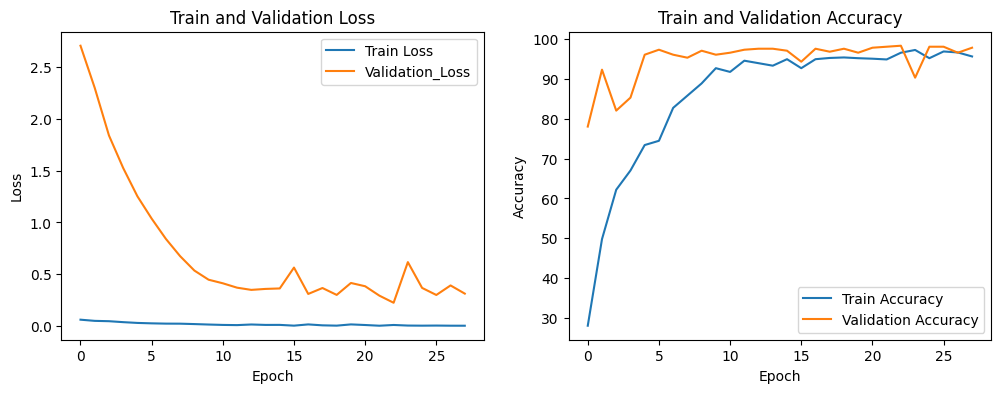

In [5]:
# 리스트의 각 텐서를 numpy 배열로 변환
train_losses_np = [loss.detach().numpy() for loss in train_losses]

# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_np, label="Train Loss")
plt.plot(validation_losses, label="Validation_Loss")
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 저장

In [ ]:
model_save_path = "trained_model.path"
torch.save(model.state_dict(), model_save_path)